In [9]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.pylab import rcParams
import scipy as sp
from sklearn.metrics import log_loss
import sklearn.ensemble as ens
from sklearn.preprocessing import LabelEncoder
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
import random
pd.options.mode.chained_assignment = None

## Create urls for data on github

url1 = 'https://raw.github.com/WesleyPasfield/March_Madness_2017/master/KenPom_2002_2017.csv'
url2 = 'https://raw.github.com/WesleyPasfield/March_Madness_2017/master/RegularSeasonDetailedResults.csv'
url3 = 'https://raw.github.com/WesleyPasfield/March_Madness_2017/master/Teams.csv'
url4 = 'https://raw.github.com/WesleyPasfield/March_Madness_2017/master/TourneyCompactResults.csv'
url5 = 'https://raw.github.com/WesleyPasfield/March_Madness_2017/master/TourneyDetailedResults.csv'
url6 = 'https://raw.github.com/WesleyPasfield/March_Madness_2017/master/Team_Lookup.csv'
url7 = 'https://raw.github.com/WesleyPasfield/March_Madness_2017/master/RegularSeasonCompactResults.csv'
url8 = 'https://raw.github.com/WesleyPasfield/March_Madness_2017/master/RegularSeasonStack.csv'
##url8 = 'https://raw.github.com/WesleyPasfield/March_Madness_2017/master/Stage_1.csv'
##url9 = 'https://raw.github.com/WesleyPasfield/March_Madness_2017/master/Stage_2.csv'

## Load data from urls

kp = pd.read_csv(url1)
regSeason = pd.read_csv(url2)
teams = pd.read_csv(url3)
tourneyResults = pd.read_csv(url4)
tourneyDetail = pd.read_csv(url5)
teamLookup = pd.read_csv(url6)
regSeasonComp = pd.read_csv(url7)
##stage1 = pd.read_csv(url8)
##stage2 = pd.read_csv(url9)

## Create indicators for regular season vs tourney data, then stack regular & tourney data

regSeasonComp['Type'] = 'Regular'
tourneyResults['Type'] = 'Tourney'
allDetail = pd.concat([regSeason, tourneyDetail])

In [13]:
## Change KenPom names to match Kaggle Data

teamLookup.columns = ['Team', 'Team_Name']
kp2 = kp.merge(teamLookup, on = 'Team', how = 'left')

kp2.head()


,Rank,Team,Conf,W-L,AdjEM,AdjO,AdjD,AdjT,Luck,AdjEM_SOS,OppO,OppD,AdjEM_NCSOS,Year,Team_Name
0,1,Duke,ACC,31-4,34.14,118.9,84.7,75.9,-0.027,10.09,107.8,97.7,7.52,2002,Duke
1,2,Cincinnati,CUSA,31-4,30.15,116.0,85.9,68.6,0.002,7.45,105.2,97.8,5.41,2002,Cincinnati
2,3,Maryland,ACC,32-4,29.24,117.2,88.0,74.7,0.025,10.32,107.9,97.6,5.12,2002,Maryland
3,4,Kansas,B12,31-4,28.95,116.7,87.8,78.4,0.023,10.75,108.8,98.1,8.91,2002,Kansas
4,5,Oklahoma,B12,31-5,26.02,113.0,87.0,68.2,0.044,9.39,107.8,98.4,2.55,2002,Oklahoma


In [24]:
## Change column names for team lookup, then merge to match KP names & Kaggle Names

teamLookup.columns = ['Team', 'Team_Name']
kp2 = kp.merge(teamLookup, on = 'Team', how = 'left')

## Drop Null cases (Winston Salem St. , irrelevant), & Merge with Teams to get team_ids

kp2['nullCheck'] = pd.isnull(kp2['Team_Name'])
kp2= kp2[kp2.nullCheck != True]
kp3 = kp2.merge(teams, on = 'Team_Name', how = 'left')

## Convert variables to correct format & drop irrelevant variables

kp3.drop(['Rank','Team','Conf','W-L', 'nullCheck','Team_Name'],inplace=True,axis=1,errors='ignore')

## Add in total adjusted team efficiency (adjO - adjD) & create variable for Team_Year

kp3['Team_Year'] = kp3.Year.map(str) + "_" + kp3.Team_Id.map(str)
kp3 = kp3[kp3['Year'] != 2002]

## Drop Unnecessary Variables

kp3.drop(['Year', 'Team_Id'], inplace=True, axis=1, errors='ignore')
kp3.head()

,AdjEM,AdjO,AdjD,AdjT,Luck,AdjEM_SOS,OppO,OppD,AdjEM_NCSOS,Team_Year
327,34.83,122.6,87.8,70.2,0.019,0.70,104.9,104.2,1.09,2003_1211.0
328,30.20,123.1,92.9,64.6,0.027,9.10,109.9,100.8,4.74,2003_1437.0
329,29.02,116.8,87.8,60.0,-0.067,11.39,110.2,98.8,2.64,2003_1438.0
330,28.85,119.5,90.6,71.4,-0.078,7.34,108.2,100.8,-7.21,2003_1452.0
331,27.91,117.5,89.6,68.3,0.020,10.69,110.8,100.1,4.47,2003_1257.0


In [26]:
allDetail['W_Team_Year'] = allDetail.Season.map(str) + '_' + allDetail.Wteam.map(str)
allDetail['L_Team_Year'] = allDetail.Season.map(str) + '_' + allDetail.Lteam.map(str)
#regSeasonFin= allDetail[['W_Team_Year', 'L_Team_Year', 'possW', 'possL', 'possDiff']]

allDetail.head()


,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,Lfta,Lor,Ldr,Last,Lto,Lstl,Lblk,Lpf,W_Team_Year,L_Team_Year
0,2003,10,1104,68,1328,62,N,0,27,58,...,22,10,22,8,18,9,2,20,2003_1104,2003_1328
1,2003,10,1272,70,1393,63,N,0,26,62,...,20,20,25,7,12,8,6,16,2003_1272,2003_1393
2,2003,11,1266,73,1437,61,N,0,24,58,...,23,31,22,9,12,2,5,23,2003_1266,2003_1437
3,2003,11,1296,56,1457,50,N,0,18,38,...,15,17,20,9,19,4,3,23,2003_1296,2003_1457
4,2003,11,1400,77,1208,71,N,0,30,61,...,27,21,15,12,10,7,1,14,2003_1400,2003_1208


In [107]:
## Get Team_Year combinations, then create df for all game winners & losers

allDetail['W_Team_Year'] = allDetail.Season.map(str) + '_' + allDetail.Wteam.map(str)
allDetail['L_Team_Year'] = allDetail.Season.map(str) + '_' + allDetail.Lteam.map(str)
regSeasonFin= allDetail[['W_Team_Year', 'L_Team_Year', 'possW', 'possL', 'possDiff']]

## Create KP file that just has adjO, adjD, & AdjS for merging

kp4 = kp3[['Team_Year', 'AdjO','AdjD','AdjS']]

## Merge Ken Pom data with regSeason data
## Understand how season long stats predict game by game

regSeasonFin2 = regSeasonFin.merge(kp4, left_on = 'W_Team_Year', right_on = 'Team_Year')
regSeasonFin3 = regSeasonFin2.merge(kp4, left_on = 'L_Team_Year', right_on = 'Team_Year')
regSeasonFin3.columns = ['W_Team_Year', 'L_Team_Year', 'possW', 'possL', 
                         'possDiff', 'W_Team_Year2','W_AdjO','W_AdjD','W_AdjS',
                        'L_Team_Year2', 'L_AdjO', 'L_AdjD', 'L_AdjS']

## Find game by game season based expected differences between two teams, then compare with averages

## Create z score for all variables

cols = list(kp3.columns)
cols.remove('Team_Year')



for col in cols:
    col_zscore = col + '_zscore'
    kp3[col_zscore] = (kp3[col] - kp3[col].mean())/kp3[col].std(ddof=0)
    
# Pull out only z score tranformed variables
kpFin = kp3[kp3.columns[10:21]]
kpFin.head()

regSeasonFin4 = regSeasonFin3
regSeasonFin4['W_expO'] = (regSeasonFin3['W_AdjO'] + regSeasonFin3['L_AdjD']) / 2
regSeasonFin4['W_expD'] = (regSeasonFin3['W_AdjD'] + regSeasonFin3['L_AdjO']) / 2
regSeasonFin4['L_expO'] = (regSeasonFin3['L_AdjO'] + regSeasonFin3['W_AdjD']) / 2
regSeasonFin4['L_expD'] = (regSeasonFin3['L_AdjD'] + regSeasonFin3['W_AdjO']) / 2
regSeasonFin4['expF'] = regSeasonFin3['W_AdjS'] - regSeasonFin3['L_AdjS']
regSeasonFin4['W_ActO_ExpO'] = regSeasonFin4['possW'] - regSeasonFin4['W_expO']
regSeasonFin4['W_ActD_ExpD'] = regSeasonFin4['possL'] - regSeasonFin4['W_expD']
regSeasonFin4['L_ActO_ExpO'] = regSeasonFin4['possL'] - regSeasonFin4['L_expO']
regSeasonFin4['L_ActD_ExpD'] = regSeasonFin4['possW'] - regSeasonFin4['L_expD']
regSeasonFin4['ActF-ExpF'] = regSeasonFin4['possDiff'] - regSeasonFin4['expF']
regSeasonFin4['W_ActO_ExpO_Abs'] = abs(regSeasonFin4['possW'] - regSeasonFin4['W_expO'])
regSeasonFin4['W_ActD_ExpD_Abs'] = abs(regSeasonFin4['possL'] - regSeasonFin4['W_expD'])
regSeasonFin4['L_ActO_ExpO_Abs'] = abs(regSeasonFin4['possL'] - regSeasonFin4['L_expO'])
regSeasonFin4['L_ActD_ExpD_Abs'] = abs(regSeasonFin4['possW'] - regSeasonFin4['L_expD'])
regSeasonFin4['ActF-ExpF_Abs'] = abs(regSeasonFin4['possDiff'] - regSeasonFin4['expF'])

## Create Losing team dataset

regSeasLoss = regSeasonFin4[['L_Team_Year','L_ActO_ExpO', 'L_ActO_ExpO_Abs', 
                             'L_ActD_ExpD','L_ActD_ExpD_Abs','ActF-ExpF','ActF-ExpF_Abs']]

## Create winning team dataset
                                                            
regSeasWin = regSeasonFin4[['W_Team_Year','W_ActO_ExpO', 'W_ActO_ExpO_Abs', 'W_ActD_ExpD',
                             'W_ActD_ExpD_Abs', 'ActF-ExpF', 'ActF-ExpF_Abs']]

## Rename columns

regSeasLoss.columns = ['Team_Year', 'AdjO_Vol', 'AdjO_Vol_Abs', 'AdjD_Vol', 'AdjD_Vol_Abs', 'AdjS_Vol', 'AdjS_Vol_Abs']
regSeasWin.columns = ['Team_Year', 'AdjO_Vol', 'AdjO_Vol_Abs', 'AdjD_Vol', 'AdjD_Vol_Abs', 'AdjS_Vol', 'AdjS_Vol_Abs']

## Stack losers & winners, then find avg, max, min & range by team/season

regSeasConcat = pd.concat([regSeasLoss, regSeasWin])
regSeasGroupAverage = regSeasConcat.groupby(['Team_Year']).mean()
regSeasGroupAverage['Team_Year'] = regSeasGroupAverage.index
regSeasGroupAverage = regSeasGroupAverage[['Team_Year', 'AdjO_Vol_Abs', 'AdjD_Vol_Abs', 'AdjS_Vol_Abs']]
regSeasGroupAverage.columns = ['Team_Year', 'AdjO_Vol_Avg', 'AdjD_Vol_Avg', 'AdjS_Vol_Avg']

regSeasGroupMax = regSeasConcat.groupby(['Team_Year']).max()
regSeasGroupMax['Team_Year'] = regSeasGroupMax.index
regSeasGroupMax = regSeasGroupMax[['Team_Year', 'AdjO_Vol' ,'AdjD_Vol', 'AdjS_Vol']]
regSeasGroupMax.columns = ['Team_Year', 'AdjO_Vol_Max' ,'AdjD_Vol_Max', 'AdjS_Vol_Max']

regSeasGroupMin = regSeasConcat.groupby(['Team_Year']).min()
regSeasGroupMin['Team_Year'] = regSeasGroupMin.index
regSeasGroupMin = regSeasGroupMin[['Team_Year', 'AdjO_Vol' ,'AdjD_Vol', 'AdjS_Vol']]
regSeasGroupMin.columns = ['Team_Year', 'AdjO_Vol_Min' ,'AdjD_Vol_Min', 'AdjS_Vol_Min']

regSeasGroupMaxMin = regSeasGroupMax.merge(regSeasGroupMin, on = 'Team_Year')
regSeasGroupMaxMin['AdjO_Vol_Range'] = regSeasGroupMaxMin['AdjO_Vol_Max'] - regSeasGroupMaxMin['AdjO_Vol_Min']
regSeasGroupMaxMin['AdjD_Vol_Range'] = regSeasGroupMaxMin['AdjD_Vol_Max'] - regSeasGroupMaxMin['AdjD_Vol_Min']
regSeasGroupMaxMin['AdjS_Vol_Range'] = regSeasGroupMaxMin['AdjS_Vol_Max'] - regSeasGroupMaxMin['AdjS_Vol_Min']
regSeasGroupFin = regSeasGroupMaxMin.merge(regSeasGroupAverage, on = 'Team_Year')
regSeasGroupFin.index = regSeasGroupFin['Team_Year']
regSeasGroupFin.head(n =10)


## Create z score for all variables

cols = list(regSeasGroupFin.columns)
cols.remove('Team_Year')

for col in cols:
    col_zscore = col + '_zscore'
    regSeasGroupFin[col_zscore] = (regSeasGroupFin[col] - regSeasGroupFin[col].mean())/regSeasGroupFin[col].std(ddof=0)
    
regSeasMerge = regSeasGroupFin[['Team_Year', 'AdjO_Vol_Max_zscore', 'AdjD_Vol_Max_zscore',
                               'AdjS_Vol_Max_zscore', 'AdjO_Vol_Min_zscore', 'AdjD_Vol_Min_zscore',
                               'AdjS_Vol_Min_zscore', 'AdjO_Vol_Range_zscore', 'AdjD_Vol_Range_zscore',
                               'AdjS_Vol_Range_zscore', 'AdjO_Vol_Avg_zscore', 'AdjD_Vol_Avg_zscore',
                               'AdjS_Vol_Avg_zscore']]


kpMerge = kpFin.merge(regSeasMerge, on = 'Team_Year', how = 'left')
kpLogData = kp3.merge(regSeasGroupFin, on = 'Team_Year', how = 'left')

In [108]:
## Take log of all variables

cols = list(kpLogData.columns)
cols.remove('Team_Year')

for col in cols:
    col_log = col + '_log'
    kpLogData[col_log] = np.log(kpLogData[col])
    
## Pull out only useful log transforms 
kpLog = kpLogData[['Team_Year','AdjO_Vol_Range_log', 'AdjD_Vol_Range_log', 'AdjS_Vol_Range_log',
                  'AdjO_Vol_Avg_log', 'AdjD_Vol_Avg_log', 'AdjS_Vol_Avg_log']]

## Take exp of Relevant variables

cols = list(kpLogData.columns)
cols.remove('Team_Year')

for col in cols:
    col_exp = col + '_exp'
    kpLogData[col_exp] = np.exp(kpLogData[col])
    
## Pull out only useful exp tranformed variables

## Merge transformed variables and drop unnecessary variables

kpExp = kpLogData[['Team_Year', 'Pyth_NCSOS_exp', 'Luck_exp']]

kpTransformed = kpMerge.merge(kpExp, on = 'Team_Year', how = 'left')
kpMergeFinal = kpTransformed.merge(kpLog, on = 'Team_Year', how = 'left')
kpMergeFinal.drop(['Luck_zscore', 'Pyth_NCSOS_zscore' ,'AdjO_Vol_Avg_zscore' ,'AdjD_Vol_Avg_zscore',
                  'AdjS_Vol_Avg_zscore', 'AdjO_Vol_Range_zscore', 'AdjD_Vol_Range_zscore', 'AdjS_Vol_Range_zscore']
                 ,inplace=True,axis=1,errors='ignore')

In [109]:
## Stack tournament & regular season stats on top of one another, then merge with KenPom

regUse = regSeasonComp[['Wteam', 'Lteam', 'Home', 'Neutral', 'Away', 'Win', 'Type']]
tourneyUse = tourneyResults[['Wteam', 'Lteam', 'Home', 'Neutral', 'Away', 'Win', 'Type']]

allUse = pd.concat([regUse, tourneyUse])

kpModel = allUse.merge(kpMergeFinal, left_on = 'Wteam', right_on = 'Team_Year')
kpModel = kpModel.merge(kpMergeFinal, left_on = 'Lteam', right_on = 'Team_Year')

## Model using difference between the two teams across all variables

kpModel['Pyth_diff'] = kpModel['Pyth_zscore_x'] - kpModel['Pyth_zscore_y']
kpModel['AdjO_diff'] = kpModel['AdjO_zscore_x'] - kpModel['AdjO_zscore_y']
kpModel['AdjD_diff'] = kpModel['AdjD_zscore_x'] - kpModel['AdjD_zscore_y']
kpModel['AdjS_diff'] = kpModel['AdjS_zscore_x'] - kpModel['AdjS_zscore_y']
kpModel['AdjT_diff'] = kpModel['AdjT_zscore_x'] - kpModel['AdjT_zscore_y']
kpModel['Luck_diff'] = kpModel['Luck_exp_x'] - kpModel['Luck_exp_y']
kpModel['Pyth_SOS_diff'] = kpModel['Pyth_SOS_zscore_x'] - kpModel['Pyth_SOS_zscore_y']
kpModel['OppO_diff'] = kpModel['OppO_zscore_x'] - kpModel['OppO_zscore_y']
kpModel['OppD_diff'] = kpModel['OppD_zscore_x'] - kpModel['OppD_zscore_y']
kpModel['Pyth_NCSOS_diff'] = kpModel['Pyth_NCSOS_exp_x'] - kpModel['Pyth_NCSOS_exp_y']
kpModel['AdjO_Vol_Max_diff'] = kpModel['AdjO_Vol_Max_zscore_x'] - kpModel['AdjO_Vol_Max_zscore_y']
kpModel['AdjD_Vol_Max_diff'] = kpModel['AdjD_Vol_Max_zscore_x'] - kpModel['AdjD_Vol_Max_zscore_y']
kpModel['AdjS_Vol_Max_diff'] = kpModel['AdjS_Vol_Max_zscore_x'] - kpModel['AdjS_Vol_Max_zscore_y']
kpModel['AdjO_Vol_Min_diff'] = kpModel['AdjO_Vol_Min_zscore_x'] - kpModel['AdjO_Vol_Min_zscore_y']
kpModel['AdjD_Vol_Min_diff'] = kpModel['AdjD_Vol_Min_zscore_x'] - kpModel['AdjD_Vol_Min_zscore_y']
kpModel['AdjS_Vol_Min_diff'] = kpModel['AdjS_Vol_Min_zscore_x'] - kpModel['AdjS_Vol_Min_zscore_y']
kpModel['AdjO_Vol_Range_diff'] = kpModel['AdjO_Vol_Range_log_x'] - kpModel['AdjO_Vol_Range_log_y']
kpModel['AdjD_Vol_Range_diff'] = kpModel['AdjD_Vol_Range_log_x'] - kpModel['AdjD_Vol_Range_log_y']
kpModel['AdjS_Vol_Range_diff'] = kpModel['AdjS_Vol_Range_log_x'] - kpModel['AdjS_Vol_Range_log_y']
kpModel['AdjO_Vol_Avg_diff'] = kpModel['AdjO_Vol_Avg_log_x'] - kpModel['AdjO_Vol_Avg_log_y']
kpModel['AdjD_Vol_Avg_diff'] = kpModel['AdjD_Vol_Avg_log_x'] - kpModel['AdjD_Vol_Avg_log_y']
kpModel['AdjS_Vol_Avg_diff'] = kpModel['AdjS_Vol_Avg_log_x'] - kpModel['AdjS_Vol_Avg_log_y']

kpModel['id'] = kpModel.Wteam.str[:4] + '_' + kpModel.Wteam.str[4:] + '_' + kpModel.Lteam.str[4:]

kpFinal = kpModel.iloc[:,[2,3,4,5,6,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75]]
Target = 'Win'
IDcol = 'id'
Type = 'Type'

In [110]:
rcParams['figure.figsize'] = 12,4
random.seed(42)
tIndex = np.random.rand(len(kpFinal)) < 0.75
X_train = kpFinal[tIndex]
X_test = kpFinal[~tIndex]
X_testWin = pd.DataFrame({'Win': X_test['Win'],
                         'id': X_test['id'],
                         'Type': X_test['Type']})
X_trainWin = pd.DataFrame({'Win': X_train['Win'],
                         'id': X_train['id'],
                         'Type': X_train['Type']})

def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds =5):
    ## Fit algorithm to the data
    alg.fit(dtrain[predictors], dtrain['Win'])
    ## Predict Training Set
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob=alg.predict_proba(dtrain[predictors])[:,1]
    ## Perform Cross validation
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['Win'], 
                                                    cv=cv_folds, scoring = 'roc_auc')
    ## Print model report
    print("\nModel Report")
    print("Accuracy: %.4g" % metrics.accuracy_score(dtrain['Win'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Win'], dtrain_predprob))
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" 
        % (np.mean(cv_score), np.std(cv_score), np.min(cv_score), np.max(cv_score)))
        
    ## Print Feature Importance
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature_Importances')
        
predictors = [x for x in X_train.columns if x not in [Target, IDcol, Type]]

## Grid Search example - removed grid searches for ease of viewing

#param_test1 = {'n_estimators': [50, 75, 100]}
#gSearch1 = GridSearchCV(estimator = ens.GradientBoostingClassifier(max_depth =5 , learning_rate = 0.1, min_samples_split = 500,
#                                          min_samples_leaf = 50, max_features = 'sqrt', subsample= .80,
#                                         random_state = 10),
#param_grid = param_test1, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
#gSearch1.fit(X_train[predictors],X_train[Target])
#modelfit(gSearch1, X_train, predictors)



Model Report
Accuracy: 0.8153
AUC Score (Train): 0.902337


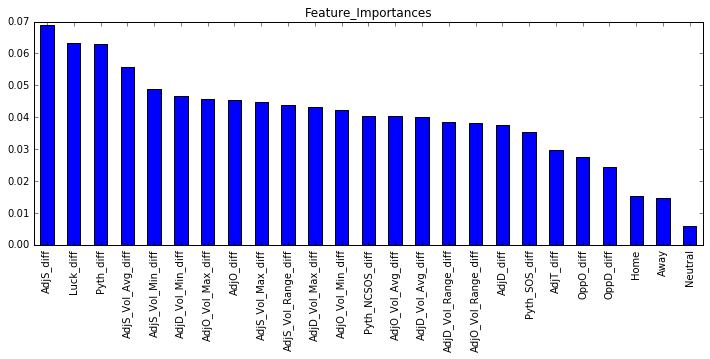

In [63]:
gbmFin = ens.GradientBoostingClassifier(max_depth = 7 , learning_rate = 0.025, min_samples_split = 250,
                                          min_samples_leaf = 50, max_features = 'sqrt', subsample= .80,
                                         random_state = 10, n_estimators = 1000)
modelfit(gbmFin, X_train, predictors, performCV = False, printFeatureImportance = True)

In [111]:
rcParams['figure.figsize'] = 12,4

tIndex = np.random.rand(len(kpFinal)) < 0.75
X_train = kpFinal[tIndex]
X_test = kpFinal[~tIndex]
X_testWin = pd.DataFrame({'Win': X_test['Win'],
                         'id': X_test['id'],
                         'Type': X_test['Type']})
X_trainWin = pd.DataFrame({'Win': X_train['Win'],
                         'id': X_train['id'],
                         'Type': X_train['Type']})

def modelfitXGB(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain['Win'].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Win'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Win'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Win'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

## Example Grid Search for xgboost - removed all for space reasons    
    
#param_test3 = {
# 'reg_lambda':[i/1.0 for i in range(0,5)]
#}

#gsearch3 = GridSearchCV(estimator = XGBClassifier(max_depth =7 , learning_rate = 0.1, n_estimators = 100,
#                        subsample= .80, colsample_bytree =.75, 
#                        objective = 'binary:logistic'),
#                        param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
#gsearch3.fit(X_train[predictors],X_train[Target])
#gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_



Model Report
Accuracy : 0.8126
AUC Score (Train): 0.901025


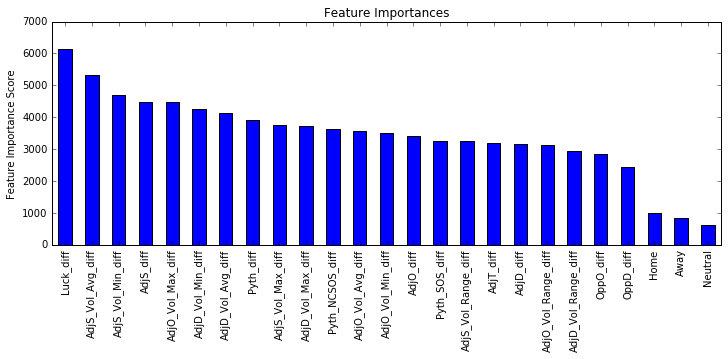

In [70]:
## xgboost model

xgb2 = XGBClassifier(max_depth = 7 , learning_rate = 0.015, n_estimators = 1000,
                        subsample= .80, colsample_bytree =.75, reg_lambda = 3, gamma = 0.5,
                        objective = 'binary:logistic')

modelfitXGB(xgb2, X_train, predictors)

In [112]:
## Purpose of this chart is to get an understanding of how predicted probabilities translate to actual wins
## As well as an understanding of the prediction distribution across percentages

## NOTE - in order to run this need to have a completed model, then create a dataframe 
## that contains the predicted chance of winning & actual outcome for each game in the test set

## Create dataframe with predicted win % and actual result for each game from predicted test set
## predTest DataFrame houses my predictions, and X_testWin houses the outcome of the predicted games

def h(df, df2, Type, model):

    ## Pull out desired type (regular vs. tournament)
    
    df = df[df['Type']==Type]
    df2 = df2[df2['Type']==Type]
    df.drop(['id','Win','Type'],inplace=True,axis=1,errors='ignore')
    predTest = model.predict_proba(df)
    predTestComp = pd.DataFrame({'pred' : predTest[:,1],
                             'Win': df2['Win'],
                            'Type' : df2['Type'],
                            'id' : df2['id']})

    ## Round prediction % for ease of interpretation

    predTestComp['predRound'] = np.round(predTestComp['pred'], decimals=2)      
    
    ## Find Difference in predictions vs actuals, as well as max miss & print results
    ## Also find number of "correct" predictions - above 50% and win / below 50% and loss
    ## Then print the results
    
    predTestComp['diff'] = abs(predTestComp['Win'] - predTestComp['pred'])
    maximum = np.round(max(predTestComp['diff']),decimals = 4)
    def f(df3):
        if df3['diff'] < 0.5:
            val = 1
        else:
            val = 0
        return val

    predTestComp['bin'] = predTestComp.apply(f, axis=1)
    accuracy = np.round(sum(predTestComp['bin']) / len(predTestComp),decimals = 4)
    print('The Biggest Upset is', maximum)
    print('Accuracy is', accuracy)
    
    ## Now Calc AUC
    
    y = np.array(predTestComp['Win']+1)
    pred = np.array(predTestComp['pred'])
    fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2)
    auc = np.round(metrics.auc(fpr, tpr),decimals=4)
    print('AUC is', auc)
    predTestComp.drop(['Type'],inplace=True,axis=1,errors='ignore')
    predTestComp.drop(['id'],inplace=True,axis=1,errors='ignore')
    
    ## Now Calc LogLoss
    
    yLL = list(predTestComp['Win'])
    logL = log_loss(yLL, predTest)
    print('LogLoss is', logL)
    
    ## Group predictions by predicted win percentage, then find the total number of wins, games & average win percentage 
    ## For each rounded prediction value (0-100%)

    grouped = predTestComp.groupby(['predRound'])['Win'].agg(['sum', 'count', 'mean']).reset_index()

    ## Create subplots that have win% on the x axis, and number of games on the secondary axis
    fig, tsax = plt.subplots(figsize=(12,5))
    barax = tsax.twinx() 

    ## Create bar chart based on the count of games for each predicted percentage

    barax.bar(grouped.index, grouped['count'], facecolor=(0.5, 0.5, 0.5), alpha=0.3) 

    ## Create line chart that shows the average win percentage by predicted percentage

    fig.tight_layout()
    tsax.plot(grouped.index, grouped['mean'], color = 'b')

    ## Set axis & data point labels as well as tick distribution

    barax.set_ylabel('Number of Games')
    barax.xaxis.tick_top()
    tsax.set_ylabel('Win %')
    tsax.set_xlabel('Predicted Win %')
    tsax.set_xlim([0, 101])
    tsax.set_ylim([0, 1])
    plt.xticks(np.arange(0, 101, 10))
    percListX = ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
    percListY = ['0%', '20%', '40%', '60%', '80%', '100%']
    tsax.set_xticklabels(percListX)
    tsax.set_yticklabels(percListY)

    ## Put line graph in front of bar chart

    tsax.set_zorder(barax.get_zorder()+1) 
    tsax.patch.set_visible(False) # hide the 'canvas' 

    ## Create legend labels - necessary because it's a subplot

    line_patch = mpatches.Patch(color='blue', label='Percentage of Games Won')
    bar_patch = mpatches.Patch(color='gray', label='Number of Games')
    plt.legend(handles=[line_patch, bar_patch], loc = 'upper center')
    plt.savefig('output.png', dpi=300)
                  

In [113]:
## Same as above function but for ensemble model
## In future - turn into if statement in one function to evaluate ensemble or individual model
## Also don't have log loss working for ensemble eval

def e(df, df2, Type):
    df.drop(['id','Win','Type'],inplace=True,axis=1,errors='ignore')
    predTest = gbmFin.predict_proba(df)
    predTest2 = xgb2.predict_proba(df)
    predTestComp = pd.DataFrame({'pred' : predTest[:,1],
                                 'pred2' : predTest2[:,1],
                                 'Win': df2['Win'],
                                'Type': df2['Type']})
    predTestComp['predAvg'] = predTestComp[["pred", "pred2"]].mean(axis=1)

    ## Round prediction % for ease of interpretation

    predTestComp['predRound'] = np.round(predTestComp['predAvg'], decimals=2) 
    
    ## Pull out desired type (regular vs. tournament)
    
    predTestComp = predTestComp[predTestComp['Type']==Type] 
    
    ## Find Difference in predictions vs actuals, as well as max miss & print results
    ## Also find number of "correct" predictions - above 50% and win / below 50% and loss
    ## Then print the results
    
    predTestComp['diff'] = abs(predTestComp['Win'] - predTestComp['predAvg'])
    maximum = np.round(max(predTestComp['diff']),decimals = 4)
    def f(df3):
        if df3['diff'] < 0.5:
            val = 1
        else:
            val = 0
        return val

    predTestComp['bin'] = predTestComp.apply(f, axis=1)
    accuracy = np.round(sum(predTestComp['bin']) / len(predTestComp),decimals = 4)
    print('The Biggest Upset Is', maximum)
    print('Accuracy Is', accuracy)
    
    ## Now Calc AUC
    
    y = np.array(predTestComp['Win']+1)
    pred = np.array(predTestComp['predAvg'])
    fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2)
    auc = np.round(metrics.auc(fpr, tpr),decimals=4)
    print('AUC is', auc)
    predTestComp.drop(['Type'],inplace=True,axis=1,errors='ignore')
    predTestComp.drop(['id'],inplace=True,axis=1,errors='ignore')
    
    ## Group predictions by predicted win percentage, then find the total number of wins, games & average win percentage 
    ## For each rounded prediction value (0-100%)

    grouped = predTestComp.groupby(['predRound'])['Win'].agg(['sum', 'count', 'mean']).reset_index()

    ## Create subplots that have win% on the x axis, and number of games on the secondary axis
    fig, tsax = plt.subplots(figsize=(12,5))
    barax = tsax.twinx() 

    ## Create bar chart based on the count of games for each predicted percentage

    barax.bar(grouped.index, grouped['count'], facecolor=(0.5, 0.5, 0.5), alpha=0.3) 

    ## Create line chart that shows the average win percentage by predicted percentage

    fig.tight_layout()
    tsax.plot(grouped.index, grouped['mean'], color = 'b')

    ## Set axis & data point labels as well as tick distribution

    barax.set_ylabel('Number of Games')
    barax.xaxis.tick_top()
    tsax.set_ylabel('Win %')
    tsax.set_xlabel('Predicted Win %')
    tsax.set_xlim([0, 101])
    tsax.set_ylim([0, 1])
    plt.xticks(np.arange(0, 101, 10))
    percListX = ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
    percListY = ['0%', '20%', '40%', '60%', '80%', '100%']
    tsax.set_xticklabels(percListX)
    tsax.set_yticklabels(percListY)

    ## Put line graph in front of bar chart

    tsax.set_zorder(barax.get_zorder()+1) 
    tsax.patch.set_visible(False) # hide the 'canvas' 

    ## Create legend labels - necessary because it's a subplot

    line_patch = mpatches.Patch(color='blue', label='Percentage of Games Won')
    bar_patch = mpatches.Patch(color='gray', label='Number of Games')
    plt.legend(handles=[line_patch, bar_patch], loc = 'upper center')
    plt.savefig('output.png', dpi=300)

The Biggest Upset Is 0.9837
Accuracy Is 0.8044
AUC is 0.8926


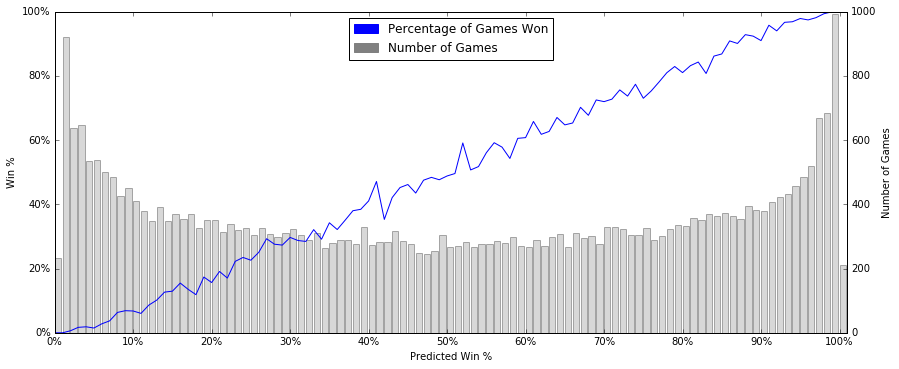

In [99]:
## Evaluate predictions on training & test sets for gbm & xgboost

rcParams['figure.figsize'] = 12,4
random.seed(42)
tIndex = np.random.rand(len(kpFinal)) < 0.75
X_train = kpFinal[tIndex]
X_test = kpFinal[~tIndex]
X_testWin = pd.DataFrame({'Win': X_test['Win'],
                         'id': X_test['id'],
                        'Type': X_test['Type']})
X_trainWin = pd.DataFrame({'Win': X_train['Win'],
                            'id': X_train['id'],
                            'Type': X_train['Type']})

## Uncomment one of the below function calls to visualize results

#h(X_train, X_trainWin, 'Regular', gbmFin)
#h(X_train, X_trainWin, 'Tourney', gbmFin)
#h(X_test, X_testWin, 'Regular', gbmFin)
#h(X_test, X_testWin, 'Tourney', gbmFin)
#h(X_train, X_trainWin, 'Regular', xgb2)
#h(X_train, X_trainWin, 'Tourney', xgb2)
#h(X_test, X_testWin, 'Regular', xgb2)
#h(X_test, X_testWin, 'Tourney', xgb2)

## Evaluate predictions on training & test sets for ensemble

#e(X_train, X_trainWin, 'Regular')
#e(X_train, X_trainWin, 'Tourney')
#e(X_test, X_testWin, 'Regular')
#e(X_test, X_testWin, 'Tourney')



In [102]:
## Test Predictor

## Add in code to just pull out 2016 results

kpModelStage2 = stage2.merge(kpMergeFinal, left_on = 'Wteam', right_on = 'Team_Year')
kpModelStage2 = kpModelStage2.merge(kpMergeFinal, left_on = 'Lteam', right_on = 'Team_Year')

kpModelStage2['Pyth_diff'] = kpModelStage2['Pyth_zscore_x'] - kpModelStage2['Pyth_zscore_y']
kpModelStage2['AdjO_diff'] = kpModelStage2['AdjO_zscore_x'] - kpModelStage2['AdjO_zscore_y']
kpModelStage2['AdjD_diff'] = kpModelStage2['AdjD_zscore_x'] - kpModelStage2['AdjD_zscore_y']
kpModelStage2['AdjS_diff'] = kpModelStage2['AdjS_zscore_x'] - kpModelStage2['AdjS_zscore_y']
kpModelStage2['AdjT_diff'] = kpModelStage2['AdjT_zscore_x'] - kpModelStage2['AdjT_zscore_y']
kpModelStage2['Luck_diff'] = kpModelStage2['Luck_exp_x'] - kpModelStage2['Luck_exp_y']
kpModelStage2['Pyth_SOS_diff'] = kpModelStage2['Pyth_SOS_zscore_x'] - kpModelStage2['Pyth_SOS_zscore_y']
kpModelStage2['OppO_diff'] = kpModelStage2['OppO_zscore_x'] - kpModelStage2['OppO_zscore_y']
kpModelStage2['OppD_diff'] = kpModelStage2['OppD_zscore_x'] - kpModelStage2['OppD_zscore_y']
kpModelStage2['Pyth_NCSOS_diff'] = kpModelStage2['Pyth_NCSOS_exp_x'] - kpModelStage2['Pyth_NCSOS_exp_y']
kpModelStage2['AdjO_Vol_Max_diff'] = kpModelStage2['AdjO_Vol_Max_zscore_x'] - kpModelStage2['AdjO_Vol_Max_zscore_y']
kpModelStage2['AdjD_Vol_Max_diff'] = kpModelStage2['AdjD_Vol_Max_zscore_x'] - kpModelStage2['AdjD_Vol_Max_zscore_y']
kpModelStage2['AdjS_Vol_Max_diff'] = kpModelStage2['AdjS_Vol_Max_zscore_x'] - kpModelStage2['AdjS_Vol_Max_zscore_y']
kpModelStage2['AdjO_Vol_Min_diff'] = kpModelStage2['AdjO_Vol_Min_zscore_x'] - kpModelStage2['AdjO_Vol_Min_zscore_y']
kpModelStage2['AdjD_Vol_Min_diff'] = kpModelStage2['AdjD_Vol_Min_zscore_x'] - kpModelStage2['AdjD_Vol_Min_zscore_y']
kpModelStage2['AdjS_Vol_Min_diff'] = kpModelStage2['AdjS_Vol_Min_zscore_x'] - kpModelStage2['AdjS_Vol_Min_zscore_y']
kpModelStage2['AdjO_Vol_Range_diff'] = kpModelStage2['AdjO_Vol_Range_log_x'] - kpModelStage2['AdjO_Vol_Range_log_y']
kpModelStage2['AdjD_Vol_Range_diff'] = kpModelStage2['AdjD_Vol_Range_log_x'] - kpModelStage2['AdjD_Vol_Range_log_y']
kpModelStage2['AdjS_Vol_Range_diff'] = kpModelStage2['AdjS_Vol_Range_log_x'] - kpModelStage2['AdjS_Vol_Range_log_y']
kpModelStage2['AdjO_Vol_Avg_diff'] = kpModelStage2['AdjO_Vol_Avg_log_x'] - kpModelStage2['AdjO_Vol_Avg_log_y']
kpModelStage2['AdjD_Vol_Avg_diff'] = kpModelStage2['AdjD_Vol_Avg_log_x'] - kpModelStage2['AdjD_Vol_Avg_log_y']
kpModelStage2['AdjS_Vol_Avg_diff'] = kpModelStage2['AdjS_Vol_Avg_log_x'] - kpModelStage2['AdjS_Vol_Avg_log_y']

kpModelStage2['id'] = kpModelStage2.Wteam.str[:4] + '_' + kpModelStage2.Wteam.str[4:] + '_' + kpModelStage2.Lteam.str[4:]
kpFinalStage2 = kpModelStage2.iloc[:,[2,3,4,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72]]

In [104]:
import os

X_testStage2 = kpFinalStage2

predSub = gbmFin.predict_proba(X_testStage2)
predSub2 = xgb2.predict_proba(X_testStage2)
predSub3 = pd.DataFrame({'pred1' : predSub[:,1],
                        'pred2' : predSub2[:,1]})
predSub3['predAvg'] = predSub3[["pred1", "pred2"]].mean(axis=1)

submission = pd.DataFrame({'id': kpModelStage2['id'],
                           'pred' : predSub[:,1]})
submission2 = pd.DataFrame({'id': kpModelStage2['id'],
                          'pred' : predSub2[:,1]})
submission3 = pd.DataFrame({'id': kpModelStage2['id'],
                           'predAvg' : predSub3['predAvg']})


path = '/Users/Wesley/Documents/Kaggle/MarchMadness'
os.chdir(path)

submission.to_csv('gbmSubmission.csv')
submission2.to_csv('xgbSubmission.csv')
submission3.to_csv('ensemble.csv')



In [ ]:
## CURRENTLY NOT WORKING , DO NOT RUN

## NEED TO BE ABLE TO RUN WITHOUT HAVING TO RERUN OTHER CODE

kpGraph2 = kpMergeFinal.drop('Team_Year', axis =1, inplace = True)
kpCol = list(kpGraph2.columns)
axes = plt.gca()

for column in kpGraph2:
    s = kpGraph2[column]
    mu = np.mean(kpGraph2[column])
    sigma = np.std(kpGraph2[column])
    count, bins, ignored = plt.hist(s, 30, normed=True)
    plt.plot(bins, 1/(sigma * np.sqrt(2*np.pi)) *
       np.exp( - (bins - mu) ** 2 / (2 * sigma ** 2)),
       linewidth = 2, color = 'r', label=column)
    plt.legend(loc=0)
    plt.figure()
    
## NOTE MUST RERUN IN [130] before continuing to replace Team_Year. Need to figure out better way of 
## deleting team_year from these graphs, but not having to rerun code to replace it